In [1]:
import json
import os.path
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

from xcube.core.store import new_data_store
from xcube.core.geom import rasterize_features
from xcube.core.geom import mask_dataset_by_geometry
from xcube.core.resampling.affine import affine_transform_dataset
from xcube.core.gridmapping import GridMapping

In [2]:
def cache_dataset(ds, path, off=False, force=False):
    if off:
        return ds
    if force or not os.path.exists(path):
        ds.to_zarr(path, mode="w")
    return xr.open_zarr(path) 

def time_to_year(ds):
    years = [pd.Timestamp(t.values).year for t in ds.time]
    return ds.assign_coords(time=xr.DataArray(years, dims='time'))

---
### Open Country Geometries

<AxesSubplot:>

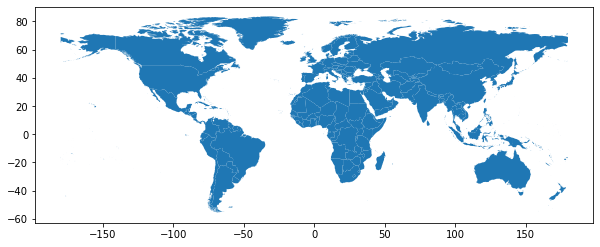

In [3]:
with open('../resources/countries-50m.geojson') as fp:
    features = json.load(fp)
features

features = gpd.GeoDataFrame.from_features(features)
features.plot(figsize=(10, 10))

In [4]:
#features

In [5]:
#desired_point = dict(lon=38., lat=0.)
#desired_country = 'Kenya'

desired_point = dict(lon=-4.75, lat=40.35)
desired_country = 'Spain'

desired_feature = features.loc[features['sovereignt'] == desired_country]
desired_feature

,geometry,scalerank,featurecla,labelrank,sovereignt,sov_a3,adm0_dif,level,type,admin,...,continent,region_un,subregion,region_wb,name_len,long_len,abbrev_len,tiny,homepart,filename
170,"MULTIPOLYGON (((-17.88794 27.80957, -17.98477 ...",1,Admin-0 country,2,Spain,ESP,0,2,Sovereign country,Spain,...,Europe,Europe,Southern Europe,Europe & Central Asia,5,5,3,-99,1,ESP.geojson


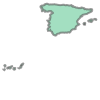

In [6]:
desired_geometry = desired_feature.iloc[0].geometry
desired_geometry

---
### Inspect CCI-Toolbox' Zarr Store (high performance data access)

In [7]:
store = new_data_store('ccizarr')

In [8]:
list(store.get_data_ids())

['BICEP-OC-L3S-PP-MERGED-1M_MONTHLY_9km_mapped-1998-2020-fv4.2.zarr',
 'ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-2018-fv2.0.zarr',
 'ESACCI-GHG-L2-CH4-SCIAMACHY-WFMD-2002-2011-fv1.zarr',
 'ESACCI-GHG-L2-CO2-SCIAMACHY-WFMD-2002-2012-fv1.zarr',
 'ESACCI-ICESHEETS_Antarctica_GMB-2002-2016-v1.1.zarr',
 'ESACCI-ICESHEETS_Greenland_GMB-2003-2016-v1.1.zarr',
 'ESACCI-L3C_CLOUD-CLD_PRODUCTS-AVHRR_NOAA-1982-2016-fv3.0.zarr',
 'ESACCI-L3C_SNOW-SWE-1979-2018-fv1.0.zarr',
 'ESACCI-L4_GHRSST-SST-GMPE-GLOB_CDR2.0-1981-2016-v02.0-fv01.0.zarr',
 'ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-2015-v2.0.7b.zarr',
 'ESACCI-OC-L3S-IOP-MERGED-1M_MONTHLY_4km_GEO_PML_OCx_QAA-1997-2020-fv5.0.zarr',
 'ESACCI-PERMAFROST-L4-ALT-MODISLST-AREA4_PP-1997-2018-fv02.0.zarr',
 'ESACCI-SEAICE-L3C-SITHICK-RA2_ENVISAT-NH25KMEASE2-2002-2012-fv2.0.zarr',
 'ESACCI-SEAICE-L3C-SITHICK-RA2_ENVISAT-NH25KMEASE2-2002-2012-fv2_4326.zarr',
 'ESACCI-SEAICE-L3C-SITHICK-RA2_ENVISAT-NH25KMEASE2-2002-2012-fv2_repro.zarr',
 'ESACCI-SEAICE-L3C-SITHICK

---
### Open Land Cover ECV

In [9]:
drop_variables = ['change_count', 'current_pixel_state', 'observation_count', 'processed_flag']  # Not needed
lc_dataset = store.open_data('ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-2015-v2.0.7b.zarr',
                             drop_variables=drop_variables)
lc_dataset

,Array,Chunk
Bytes,750.85 GiB,12.81 MiB
Shape,"(24, 64800, 129600)","(1, 2592, 1296)"
Count,60001 Tasks,60000 Chunks
Type,float32,numpy.ndarray


In [10]:
lc_dataset.lccs_class

,Array,Chunk
Bytes,750.85 GiB,12.81 MiB
Shape,"(24, 64800, 129600)","(1, 2592, 1296)"
Count,60001 Tasks,60000 Chunks
Type,float32,numpy.ndarray


In [11]:
lc_dataset.time

<xarray.DataArray 'time' (time: 24)>
array(['1992-07-02T00:00:00.000000000', '1993-07-03T00:00:00.000000000',
       '1994-07-03T00:00:00.000000000', '1995-07-03T00:00:00.000000000',
       '1996-07-02T00:00:00.000000000', '1997-07-03T00:00:00.000000000',
       '1998-07-03T00:00:00.000000000', '1999-07-03T00:00:00.000000000',
       '2000-07-02T00:00:00.000000000', '2001-07-03T00:00:00.000000000',
       '2002-07-03T00:00:00.000000000', '2003-07-03T00:00:00.000000000',
       '2004-07-02T00:00:00.000000000', '2005-07-03T00:00:00.000000000',
       '2006-07-03T00:00:00.000000000', '2007-07-03T00:00:00.000000000',
       '2008-07-02T00:00:00.000000000', '2009-07-03T00:00:00.000000000',
       '2010-07-03T00:00:00.000000000', '2011-07-03T00:00:00.000000000',
       '2012-07-02T00:00:00.000000000', '2013-07-03T00:00:00.000000000',
       '2014-07-03T00:00:00.000000000', '2015-07-03T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1992-07-02 1993-07-03 ... 2015-07-03

In [12]:
lc_dataset = time_to_year(lc_dataset)
lc_dataset.time

<xarray.DataArray 'time' (time: 24)>
array([1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015])
Coordinates:
  * time     (time) int64 1992 1993 1994 1995 1996 ... 2011 2012 2013 2014 2015

In [13]:
lc_dataset_subset = mask_dataset_by_geometry(lc_dataset, desired_geometry, all_touched=True)

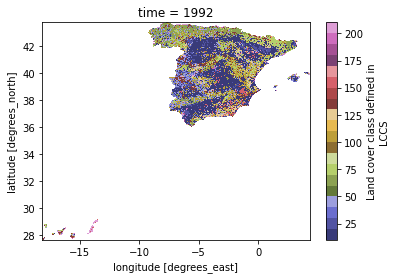

In [14]:
lc_dataset_subset.lccs_class.isel(time=0).plot.imshow(cmap="tab20b")

---
### Open Soil Moisture ECV

In [15]:
drop_variables = ['t0', 'freqbandID', 'sensor', 'mode', 'dnflag', 'flag']  # Not needed
sm_dataset = store.open_data('ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-1978-2020-fv05.3.zarr', 
                             drop_variables=drop_variables)
sm_dataset

<xarray.Dataset>
Dimensions:         (lat: 720, lon: 1440, time: 15402)
Coordinates:
  * lat             (lat) float64 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * lon             (lon) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time            (time) datetime64[ns] 1978-11-01 1978-11-02 ... 2020-12-31
Data variables:
    sm              (time, lat, lon) float32 dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sm_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                CF-1.7
    cdm_data_type:              Grid
    comment:                    This dataset was produced with funding of the...
    contact:                    cci_sm_contact@eodc.eu
    creator_email:              cci_sm_contact@eodc.eu
    creator_name:               Department of Geodesy and Geoinformation, Tec...
    ...                         ...
    time_coverage_duration:     P42Y
    time_coverage_end:          2020-12-31 00:00:00
    time_coverage_resolution:   P1D
    time_coverage_start:        1978-11-01 00:00:00
    title:                      ESA CCI Surface Soil Moisture COMBINED active...
    tracking_id:                174f51a4-6a06-4352-a712-4d3f77bd8166

In [16]:
sm_dataset.time

<xarray.DataArray 'time' (time: 15402)>
array(['1978-11-01T00:00:00.000000000', '1978-11-02T00:00:00.000000000',
       '1978-11-03T00:00:00.000000000', ..., '2020-12-29T00:00:00.000000000',
       '2020-12-30T00:00:00.000000000', '2020-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1978-11-01 1978-11-02 ... 2020-12-31
Attributes:
    standard_name:  time

In [17]:
sm_dataset_subset = mask_dataset_by_geometry(sm_dataset, desired_geometry, all_touched=True)

In [18]:
sm_dataset_subset_annual = sm_dataset_subset.resample(time='1Y').mean()

In [19]:
sm_dataset_subset_annual = time_to_year(sm_dataset_subset_annual)
sm_dataset_subset_annual.time

<xarray.DataArray 'time' (time: 43)>
array([1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020])
Coordinates:
  * time     (time) int64 1978 1979 1980 1981 1982 ... 2016 2017 2018 2019 2020

In [20]:
year_range = 2003, 2015

year_slice = slice(year_range[0], year_range[1])
sm_dataset_subset = sm_dataset_subset_annual.sel(time=slice(*year_range))
lc_dataset_subset = lc_dataset_subset.sel(time=slice(*year_range))

In [21]:
sm_dataset_subset = cache_dataset(
    sm_dataset_subset,
    f"sm_dataset_subset_{desired_country}.zarr",
    #force=True
)
sm_dataset_subset

<xarray.Dataset>
Dimensions:         (lat: 66, lon: 91, time: 13)
Coordinates:
  * lat             (lat) float64 44.12 43.88 43.62 43.38 ... 28.38 28.12 27.88
  * lon             (lon) float64 -18.12 -17.88 -17.62 ... 3.875 4.125 4.375
  * time            (time) int64 2003 2004 2005 2006 ... 2012 2013 2014 2015
Data variables:
    sm              (time, lat, lon) float32 dask.array<chunksize=(1, 66, 73), meta=np.ndarray>
    sm_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(1, 66, 73), meta=np.ndarray>

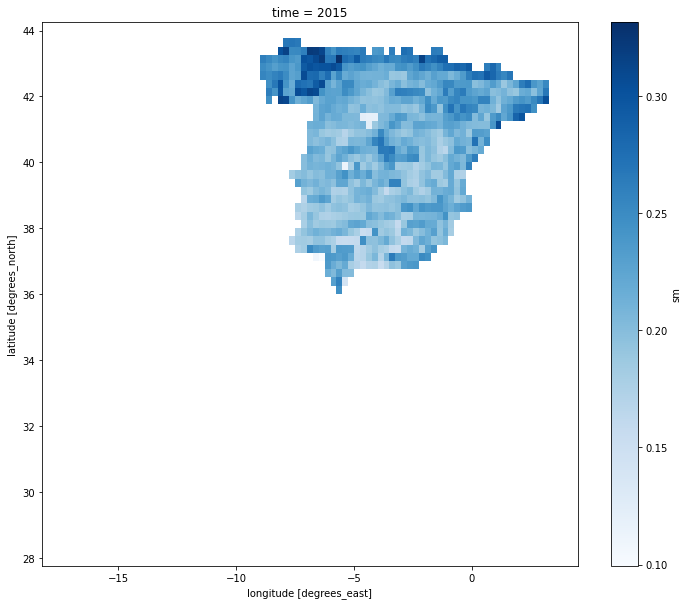

In [22]:
sm_dataset_subset.sel(time=2015).sm.plot.imshow(cmap='Blues', figsize=(12, 10))

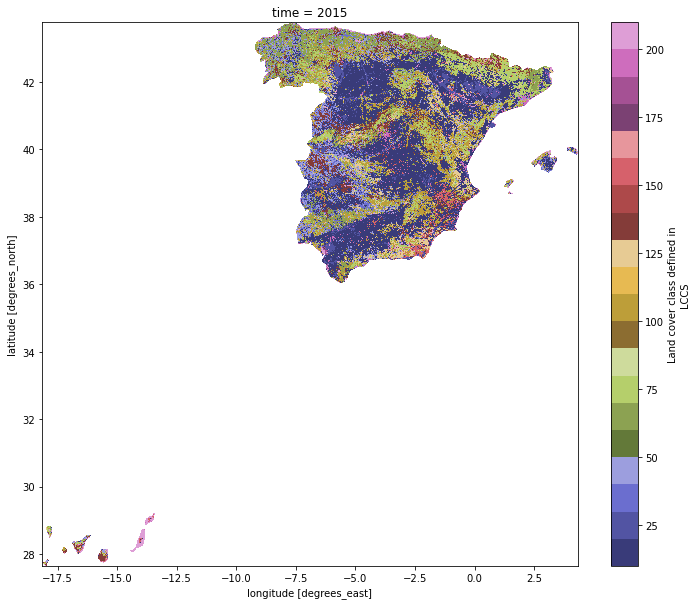

In [23]:
lc_dataset_subset.sel(time=2015).lccs_class.plot.imshow(cmap='tab20b', figsize=(12, 10))

In [24]:
sm_dataset_subset_coreg = affine_transform_dataset(
    sm_dataset_subset, 
    GridMapping.from_dataset(sm_dataset_subset),
    GridMapping.from_dataset(lc_dataset_subset),
    #reuse_coords=True,
    var_configs={
        "sm": {"spline_order": 0},
        "sm_uncertainty": {"spline_order": 0}
    }
)
# Workaround for https://github.com/pydata/xarray/issues/6573 
sm_dataset_subset_coreg = sm_dataset_subset_coreg.assign_coords(
    lat=lc_dataset_subset.lat, 
    lon=lc_dataset_subset.lon
)

In [25]:
lcc = lc_dataset_subset.lccs_class

lc_masks_and_names = [
    ((lcc >= 100) & (lcc <= 130), 'Shrubland'),
    ((lcc >= 200) & (lcc <= 240), 'Bare Areas'),
    ((lcc >= 10) & (lcc <= 30), 'Cropland'),
    ((lcc >= 50) & (lcc <= 90), 'Trees'),
]

lc_masks, lc_mask_names = zip(*lc_masks_and_names)
lc_masks, lc_mask_names = list(lc_masks), list(lc_mask_names)

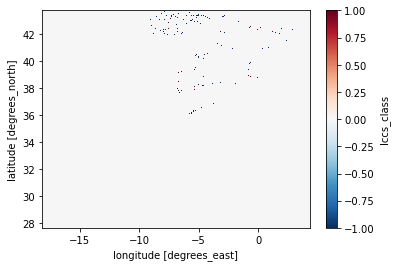

In [26]:
# Wow, there are only very liitle changes from year to year
lc_2014 = lc_masks[3].sel(time=2003)
lc_2015 = lc_masks[3].sel(time=2015)
(1.0*lc_2015 -  1.0*lc_2014).plot.imshow()

In [27]:
def get_masked_sm_timeseries(lc_mask):
    return sm_dataset_subset_coreg.where(lc_mask).mean(dim=("lat", "lon"))

In [28]:
sm_timeseries = [get_masked_sm_timeseries(lc_mask) for lc_mask in lc_masks]
sm_ts = xr.concat(sm_timeseries, "lcc")
sm_ts = sm_ts.assign_coords(lcc=xr.DataArray(lc_mask_names, dims="lcc"))

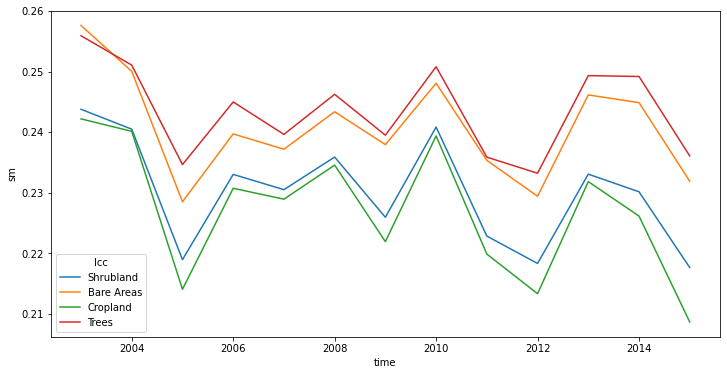

In [29]:
sm_ts.sm.plot.line(x="time", figsize=(12, 6))

In [30]:
def get_lc_counts_timeseries(lc_mask):
    return lc_mask.where(lc_mask).count(dim=('lat', 'lon'))

In [33]:
lc_timeseries = [get_lc_counts_timeseries(lc_mask) for lc_mask in lc_masks]
lc_ts = xr.concat(lc_timeseries, "lcc")
lc_ts = lc_ts.assign_coords(lcc=xr.DataArray(lc_mask_names, dims="lcc"))

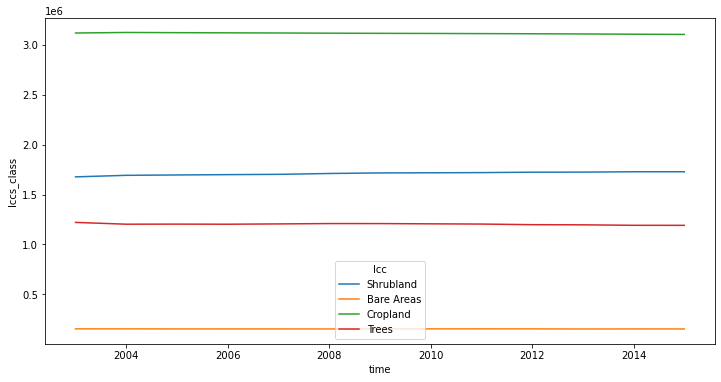

In [34]:
lc_ts.plot.line(x="time", figsize=(12, 6))

---
### Land Cover Class Frequencies

In [35]:
lc_dataset_subset_2015 = lc_dataset_subset.sel(time=2015)
lc_dataset_subset_2015 = lc_dataset_subset_2015.chunk(dict(lat=2000, lon=2000))
lc_dataset_subset_2015 = cache_dataset(
    lc_dataset_subset_2015, 
    f'lc_dataset_subset_2015_{desired_country}.zarr'
)

In [36]:
lc = lc_dataset_subset_2015.lccs_class

In [37]:
flag_values = [(fv if fv >= 0 else 256 + fv) for fv in lc.attrs['flag_values']]
list(zip(lc.attrs['flag_meanings'].split(' '), flag_values))

[('no_data', 0),
 ('cropland_rainfed', 10),
 ('cropland_rainfed_herbaceous_cover', 11),
 ('cropland_rainfed_tree_or_shrub_cover', 12),
 ('cropland_irrigated', 20),
 ('mosaic_cropland', 30),
 ('mosaic_natural_vegetation', 40),
 ('tree_broadleaved_evergreen_closed_to_open', 50),
 ('tree_broadleaved_deciduous_closed_to_open', 60),
 ('tree_broadleaved_deciduous_closed', 61),
 ('tree_broadleaved_deciduous_open', 62),
 ('tree_needleleaved_evergreen_closed_to_open', 70),
 ('tree_needleleaved_evergreen_closed', 71),
 ('tree_needleleaved_evergreen_open', 72),
 ('tree_needleleaved_deciduous_closed_to_open', 80),
 ('tree_needleleaved_deciduous_closed', 81),
 ('tree_needleleaved_deciduous_open', 82),
 ('tree_mixed', 90),
 ('mosaic_tree_and_shrub', 100),
 ('mosaic_herbaceous', 110),
 ('shrubland', 120),
 ('shrubland_evergreen', 121),
 ('shrubland_deciduous', 122),
 ('grassland', 130),
 ('lichens_and_mosses', 140),
 ('sparse_vegetation', 150),
 ('sparse_tree', 151),
 ('sparse_shrub', 152),
 ('sparse

In [38]:
lc_groups = lc.groupby(lc)

In [39]:
lc_counts = lc_groups.count()

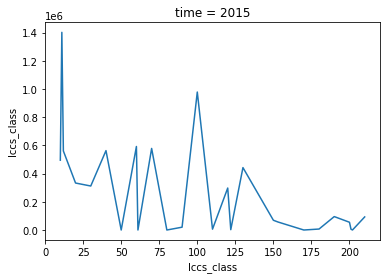

In [40]:
lc_counts.plot()

In [41]:
sorted([(int(item.lccs_class), int(item)) for item in lc_counts], key=lambda k: k[1], reverse=True) 

[(11, 1402670),
 (100, 979056),
 (60, 592642),
 (70, 578860),
 (40, 563270),
 (12, 560859),
 (10, 495453),
 (130, 442870),
 (20, 333428),
 (30, 312166),
 (120, 297849),
 (190, 95249),
 (210, 92829),
 (150, 69249),
 (153, 56955),
 (200, 55079),
 (90, 20045),
 (180, 6893),
 (110, 6110),
 (201, 5374),
 (122, 2446),
 (202, 370),
 (50, 43),
 (61, 41),
 (80, 11),
 (170, 3)]

---
### Experiments

In [42]:
lc = lc_dataset_subset.lccs_class
lc

<xarray.DataArray 'lccs_class' (time: 13, lat: 5804, lon: 8094)>
dask.array<getitem, shape=(13, 5804, 8094), dtype=float32, chunksize=(1, 2592, 1296), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 43.77 43.77 43.76 43.76 ... 27.66 27.65 27.65 27.65
  * lon      (lon) float32 -18.16 -18.16 -18.15 -18.15 ... 4.315 4.318 4.321
  * time     (time) int64 2003 2004 2005 2006 2007 ... 2011 2012 2013 2014 2015
Attributes:
    ancillary_variables:  processed_flag current_pixel_state observation_coun...
    flag_meanings:        no_data cropland_rainfed cropland_rainfed_herbaceou...
    flag_values:          [0, 10, 11, 12, 20, 30, 40, 50, 60, 61, 62, 70, 71,...
    long_name:            Land cover class defined in LCCS
    standard_name:        land_cover_lccs
    valid_max:            220
    valid_min:            1

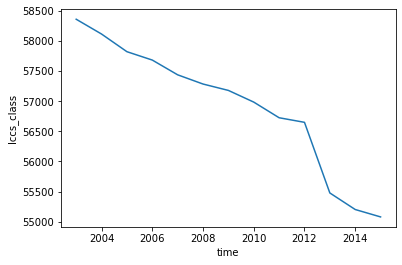

In [43]:
lc.where(lc == 200).count(dim=("lat", "lon")).plot()